In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [103]:
class NeuralNetwork:
    
    def __init__(self, layers, alpha=0.1, gd="stochastic"):
        assert gd in ["stochastic", "batch", "minibatch"], f"{gd} is not a known gradient descent method"
        self.gd = gd
        self.layers = layers
        self.depth = len(layers) - 1
        self.alpha = alpha
        # Xavier initialization: https://www.deeplearning.ai/ai-notes/initialization/
        # weights -> 0 mean and 1/layer[l-1] variance
        self.W = [(1/layers[l-1]) * np.random.randn(self.layers[l],self.layers[l-1]) for l in range(1, len(layers))]
        # bias -> 0 for all
        self.b = [np.array([0.]*layers[l]).reshape(layers[l],1) for l in range(1, len(layers))]

        
    def __repr__(self):
        return "NeuralNetwork: {}".format("-".join(str(l) for l in self.layers))
    
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    
    def dsigmoid(self,sigmoid_of_x):
        # the actual sigmoid derivative is: sigmoid(x) * (1 -sigmoid(x))
        # but since the sigmoid has already been computed, we use it directly to compute the derivative.
        return sigmoid_of_x * (1 - sigmoid_of_x)
        

    def stochGD(self, X, y, epochs):
        for epoch in range(epochs):
            for (x, target) in zip(X,y):
                A = self.feedforward(x.reshape(x.shape[0], 1))
                self.backpropagate(A, target)
       
    
    def batchGD(self, X, y, epochs):
        for epoch in range(epochs):
            A = self.feedforward(X.T)
            self.batchBackpropagate(A, y)
        
        
    def mbatchGD(self, X, y, epochs, bs = 50):
        splits = [bs * i for i in range(round(X.shape[0] / bs))]
        for epoch in range(epochs):
            for mb in np.split(np.random.permutation(X.shape[0]), splits):
                A = self.feedforward(X[mb].T)
                self.batchBackpropagate(A, y[mb])
        
    
    def fit(self, X, y, epochs=1000, bs = 50):
        if self.gd == "stochastic":
            self.stochGD(X, y, epochs)
        elif self.gd == "minibatch":
            self.mbatchGD(X, y, epochs, bs)
        else:
            self.batchGD(X, y, epochs)

    
    def feedforward(self, X):
        A = np.array([X] + [np.array([])] * self.depth)
        for i in range(self.depth):
            Z = self.W[i] @ A[i] + self.b[i]
            A[i+1] = self.sigmoid(Z)
        return A
        
    
    def backpropagate(self, A, target):
        error = A[-1] - target
        D = [2 * error * self.dsigmoid(A[-1])]
        for i in range(self.depth-1, 0, -1):
            self.b[i] -= self.alpha * D[-1]
            D += [(self.W[i].T @ D[-1].reshape(self.layers[i+1],1)) * self.dsigmoid(A[i])]
            self.W[i] -= self.alpha * D[-2].reshape(self.layers[i+1],1) @ A[i].reshape(1, self.layers[i])
            
    
    def batchBackpropagate(self, A, y):
        error = A[-1] - y
        D = [2 * error * self.dsigmoid(A[-1])]
        for i in range(self.depth-1, 0, -1):
            self.b[i] -= self.alpha * np.sum(D[-1], axis=1).reshape(self.layers[i+1],1)
            D += [(self.W[i].T @ D[-1]) * self.dsigmoid(A[i])]
            self.W[i] -= self.alpha * D[-2] @ A[i].T
            
    
    def predict(self, X):
        return self.feedforward(X.T)[-1]

In [113]:
# Initialize neural networks
nnStoch = NeuralNetwork([2,4,4,1], alpha = 0.1, gd="stochastic")
nnBatch = NeuralNetwork([2,4,4,1], alpha = 0.1, gd="batch")
nnMbatch = NeuralNetwork([2,4,4,1], alpha = 0.1, gd="minibatch")

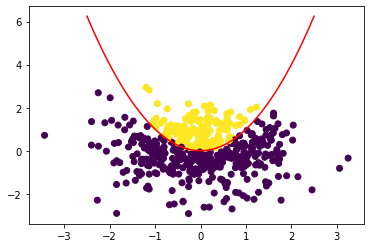

In [114]:
# Create train and test data
X = np.random.randn(500,2)
checkLine = np.linspace(-2.5, 2.5, 100)
y = (X[:,1]>X[:,0]**2).astype("int")

plt.scatter(X[:,0], X[:,1], c=y)
plt.plot(checkLine, checkLine**2, color = "red")
plt.show()

testLen = 50
X_test = np.random.randn(testLen,2)
y_test = (X_test[:,1]>X_test[:,0]**2).astype("int")

# print("X_test, y_test, y_predicted")
# print(X_test)
# print(y_test)

In [115]:
# Train neural networks
nnStoch.fit(X, y, epochs=1000)
nnBatch.fit(X, y, epochs=1000)
nnMbatch.fit(X, y, epochs=1000)

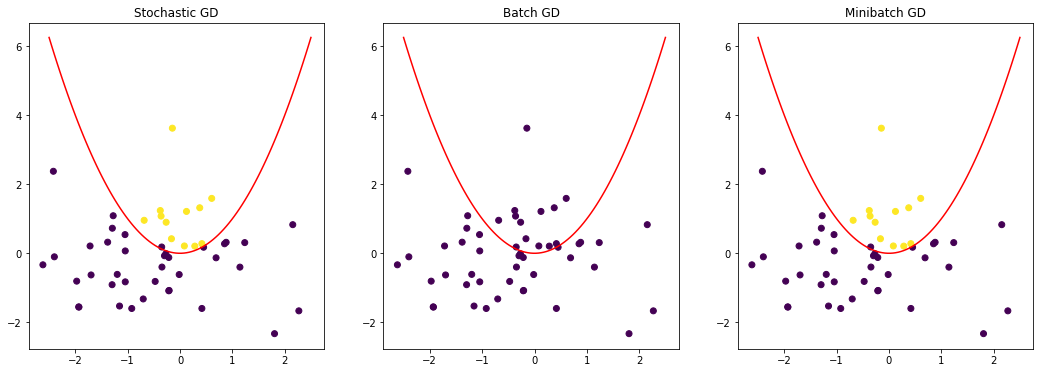

In [116]:
# Predict labels
y_Stoch = nnStoch.predict(X_test)
y_Batch = nnBatch.predict(X_test)
y_Mbatch = nnMbatch.predict(X_test)

plt.figure(figsize=(18,6))

plt.subplot(1, 3, 1)
plt.scatter(X_test[:,0], X_test[:,1], c=(y_Stoch>0.5).reshape(testLen))
plt.plot(checkLine, checkLine**2, color = "red")
plt.title('Stochastic GD')

plt.subplot(1, 3, 2)
plt.scatter(X_test[:,0], X_test[:,1], c=(y_Batch>0.5).reshape(testLen))
plt.plot(checkLine, checkLine**2, color = "red")
plt.title('Batch GD')

plt.subplot(1, 3, 3)
plt.scatter(X_test[:,0], X_test[:,1], c=(y_Mbatch>0.5).reshape(testLen))
plt.plot(checkLine, checkLine**2, color = "red")
plt.title('Minibatch GD')

plt.show()